# Building a Simple Bot with the Rasa Stack
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)


### Please make a copy of this notebook first!

If you're interested in building chatbots or voice apps with the [Rasa Stack](https://rasa.com/products/rasa-stack/), you've come to the right place! 
In this notebook you'll build a complete chatbot with Rasa Stack, without having to install anything on your computer. 

Using Colaboratory, everything will get installed in a cloud machine for you, so you can focus on creating an interesting bot. 

We'll build a relatively simple bot, that just asks you about your mood and tries to cheer you up if you're feeling a bit down. 

The tutorial consists of three parts:



*   Part 1: We'll start with a basic bot that can handle multi-turn dialogues but not understand natural language like "I'm doing well"
*   Part 2: We'll add the abilitiy to understand natural language so that the bot can generalise to similar inputs that it hasn't seen before
*   Part 3: We'll give you further resources so you can build your own.





# Part 1: Build a basic bot

### Installation
First we'll have to install Rasa Core on the server running this notebook. In this first step, your bot won't understand natural language yet. This happens in Step 2. **Run the cell below, this will take a couple of minutes to complete so this is a good time to scroll through the rest of the notebook.**

**Make sure to install the correct version. If you want to experiment with the latest master, use**: 

`!pip install -U git+https://github.com/rasahq/rasa_core.git`

In [77]:
!pip install rasa_core;

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [78]:
stories_md = """
## Transfer               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_transfer               <!-- user utterance, in format intent[entities] -->
  - utter_transfer
  - utter_confirm
* mood_goodbye
  - utter_goodbye
  
  
## Transfer path 2               <!-- this is already the start of the next story -->
* greet              
  - utter_greet
* mood_partialtransfer               <!-- user utterance, in format intent[entities] -->
  - utter_needtransfer
* mood_transfer
  - utter_transfer
  - utter_confirm
* mood_goodbye
  - utter_goodbye
  

## Transfer path 3
* greet              
  - utter_greet
* mood_partialtransfer               <!-- user utterance, in format  intent[entities] -->
  - utter_needtransfer
* mood_partialtransfer               <!-- user utterance, in format intent[entities] -->
  - utter_needtransfer
* mood_transfer
  - utter_transfer
  - utter_confirm
* mood_goodbye
  - utter_goodbye

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [79]:
domain_yml = """
intents:
  - greet
  - goodbye
  - mood_transfer
  - mood_confirm
  - mood_goodbye
  - mood_partialtransfer
  
entities:
  - amount
  - fromAcct
  - toAcct
  - date
  
slots:
  amount:
    type: text
  fromAcct:
    type: text
  toAcct:
    type: text
  date:
    type: text

actions:
- utter_greet
- utter_needtransfer
- utter_transfer
- utter_confirm
- utter_goodbye

templates:
  utter_greet:
  - text: "Hey! How are you? What would you like to transfer?"

  utter_needtransfer:
  - text: "I need some additional information to complete the transfer. 
          What is the from account, to account, amount, and date?"
  
  utter_transfer:
  - text: "Thank you for that information!"

  utter_confirm:
  - text: "I have completed the tranfer! Did that look correct?"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [80]:
from rasa_core.policies.keras_policy import KerasPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[KerasPolicy()])
training_data = agent.load_data('stories.md')
agent.train(
        training_data,
        validation_split=0.0,
        epochs=400
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 3/3 [00:00<00:00, 377.96it/s, # trackers=1]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers:  40%|████      | 8/20 [00:00<00:00, 27.98it/s, # actions=24]

Processed trackers: 100%|██████████| 20/20 [00:00<00:00, 27.31it/s, # actions=24]
INFO:rasa_core.featurizers:Created 24 action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 24 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, 5, 14)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
Total params: 6,280
Trainable params: 6,280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
24/24 [==============================] - 1s 59ms/step - loss: 2.0764 - acc: 0.0417
Epoch 2/400
24/24 [==============================] - 0s 499us/step - loss: 2.0708 - acc: 0.0833
Epoch 3/400
24/24 [==============================] - 0s 361us/step - loss: 2.0497

Epoch 32/400
24/24 [==============================] - 0s 490us/step - loss: 1.7836 - acc: 0.3750
Epoch 33/400
24/24 [==============================] - 0s 305us/step - loss: 1.7810 - acc: 0.3750
Epoch 34/400
24/24 [==============================] - 0s 436us/step - loss: 1.7711 - acc: 0.3750
Epoch 35/400
24/24 [==============================] - 0s 325us/step - loss: 1.7610 - acc: 0.3750
Epoch 36/400
24/24 [==============================] - 0s 525us/step - loss: 1.7587 - acc: 0.3750
Epoch 37/400
24/24 [==============================] - 0s 452us/step - loss: 1.7351 - acc: 0.3750
Epoch 38/400
24/24 [==============================] - 0s 454us/step - loss: 1.7273 - acc: 0.3750
Epoch 39/400
24/24 [==============================] - 0s 514us/step - loss: 1.7494 - acc: 0.3750
Epoch 40/400
24/24 [==============================] - 0s 496us/step - loss: 1.7398 - acc: 0.3750
Epoch 41/400
24/24 [==============================] - 0s 534us/step - loss: 1.7077 - acc: 0.3750
Epoch 42/400
24/24 [==========

24/24 [==============================] - 0s 471us/step - loss: 1.5430 - acc: 0.3750
Epoch 65/400
24/24 [==============================] - 0s 383us/step - loss: 1.5430 - acc: 0.3750
Epoch 66/400
24/24 [==============================] - 0s 398us/step - loss: 1.5308 - acc: 0.3750
Epoch 67/400
24/24 [==============================] - 0s 670us/step - loss: 1.5623 - acc: 0.3750
Epoch 68/400
24/24 [==============================] - 0s 337us/step - loss: 1.5161 - acc: 0.3750
Epoch 69/400
24/24 [==============================] - 0s 466us/step - loss: 1.4853 - acc: 0.3750
Epoch 70/400
24/24 [==============================] - 0s 428us/step - loss: 1.5286 - acc: 0.3750
Epoch 71/400
24/24 [==============================] - 0s 553us/step - loss: 1.5369 - acc: 0.3750
Epoch 72/400
24/24 [==============================] - 0s 471us/step - loss: 1.5039 - acc: 0.3750
Epoch 73/400
24/24 [==============================] - 0s 522us/step - loss: 1.4885 - acc: 0.3750
Epoch 74/400
24/24 [=======================

Epoch 97/400
24/24 [==============================] - 0s 345us/step - loss: 1.3281 - acc: 0.5833
Epoch 98/400
24/24 [==============================] - 0s 493us/step - loss: 1.2979 - acc: 0.5833
Epoch 99/400
24/24 [==============================] - 0s 337us/step - loss: 1.2815 - acc: 0.5833
Epoch 100/400
24/24 [==============================] - 0s 447us/step - loss: 1.2320 - acc: 0.6250
Epoch 101/400
24/24 [==============================] - 0s 580us/step - loss: 1.3160 - acc: 0.5417
Epoch 102/400
24/24 [==============================] - 0s 355us/step - loss: 1.2621 - acc: 0.6250
Epoch 103/400
24/24 [==============================] - 0s 449us/step - loss: 1.2572 - acc: 0.5833
Epoch 104/400
24/24 [==============================] - 0s 431us/step - loss: 1.2798 - acc: 0.5833
Epoch 105/400
24/24 [==============================] - 0s 468us/step - loss: 1.2638 - acc: 0.5833
Epoch 106/400
24/24 [==============================] - 0s 388us/step - loss: 1.1824 - acc: 0.7083
Epoch 107/400
24/24 [==

24/24 [==============================] - 0s 504us/step - loss: 1.0497 - acc: 0.7917
Epoch 129/400
24/24 [==============================] - 0s 461us/step - loss: 1.1398 - acc: 0.6667
Epoch 130/400
24/24 [==============================] - 0s 368us/step - loss: 1.1417 - acc: 0.5417
Epoch 131/400
24/24 [==============================] - 0s 451us/step - loss: 0.9911 - acc: 0.8333
Epoch 132/400
24/24 [==============================] - 0s 477us/step - loss: 0.9878 - acc: 0.7500
Epoch 133/400
24/24 [==============================] - 0s 482us/step - loss: 1.0799 - acc: 0.7083
Epoch 134/400
24/24 [==============================] - 0s 373us/step - loss: 0.9534 - acc: 0.7917
Epoch 135/400
24/24 [==============================] - 0s 587us/step - loss: 0.9677 - acc: 0.8333
Epoch 136/400
24/24 [==============================] - 0s 459us/step - loss: 0.9656 - acc: 0.7917
Epoch 137/400
24/24 [==============================] - 0s 378us/step - loss: 0.9697 - acc: 0.7500
Epoch 138/400
24/24 [=============

24/24 [==============================] - 0s 332us/step - loss: 0.8271 - acc: 0.8333
Epoch 160/400
24/24 [==============================] - 0s 399us/step - loss: 0.8355 - acc: 0.8750
Epoch 161/400
24/24 [==============================] - 0s 427us/step - loss: 0.9241 - acc: 0.7083
Epoch 162/400
24/24 [==============================] - 0s 473us/step - loss: 0.8953 - acc: 0.7917
Epoch 163/400
24/24 [==============================] - 0s 445us/step - loss: 0.8304 - acc: 0.7500
Epoch 164/400
24/24 [==============================] - 0s 445us/step - loss: 0.7277 - acc: 0.8750
Epoch 165/400
24/24 [==============================] - 0s 480us/step - loss: 0.7868 - acc: 0.8333
Epoch 166/400
24/24 [==============================] - 0s 459us/step - loss: 0.8233 - acc: 0.7500
Epoch 167/400
24/24 [==============================] - 0s 475us/step - loss: 0.7449 - acc: 0.8333
Epoch 168/400
24/24 [==============================] - 0s 524us/step - loss: 0.7963 - acc: 0.8333
Epoch 169/400
24/24 [=============

24/24 [==============================] - 0s 426us/step - loss: 0.5797 - acc: 0.9583
Epoch 191/400
24/24 [==============================] - 0s 525us/step - loss: 0.6256 - acc: 0.9583
Epoch 192/400
24/24 [==============================] - 0s 488us/step - loss: 0.6454 - acc: 0.9167
Epoch 193/400
24/24 [==============================] - 0s 394us/step - loss: 0.6900 - acc: 0.8750
Epoch 194/400
24/24 [==============================] - 0s 518us/step - loss: 0.6704 - acc: 0.8750
Epoch 195/400
24/24 [==============================] - 0s 439us/step - loss: 0.6016 - acc: 0.9583
Epoch 196/400
24/24 [==============================] - 0s 360us/step - loss: 0.5819 - acc: 0.9167
Epoch 197/400
24/24 [==============================] - 0s 450us/step - loss: 0.6011 - acc: 0.9583
Epoch 198/400
24/24 [==============================] - 0s 481us/step - loss: 0.6317 - acc: 0.8750
Epoch 199/400
24/24 [==============================] - 0s 549us/step - loss: 0.5919 - acc: 0.9583
Epoch 200/400
24/24 [=============

Epoch 222/400
24/24 [==============================] - 0s 458us/step - loss: 0.5537 - acc: 0.9167
Epoch 223/400
24/24 [==============================] - 0s 429us/step - loss: 0.5034 - acc: 0.9583
Epoch 224/400
24/24 [==============================] - 0s 336us/step - loss: 0.5885 - acc: 0.8750
Epoch 225/400
24/24 [==============================] - 0s 400us/step - loss: 0.5016 - acc: 0.9167
Epoch 226/400
24/24 [==============================] - 0s 557us/step - loss: 0.6005 - acc: 0.8750
Epoch 227/400
24/24 [==============================] - 0s 520us/step - loss: 0.4193 - acc: 0.9583
Epoch 228/400
24/24 [==============================] - 0s 486us/step - loss: 0.5078 - acc: 0.9583
Epoch 229/400
24/24 [==============================] - 0s 448us/step - loss: 0.4566 - acc: 0.9583
Epoch 230/400
24/24 [==============================] - 0s 470us/step - loss: 0.4954 - acc: 0.9583
Epoch 231/400
24/24 [==============================] - 0s 432us/step - loss: 0.4788 - acc: 0.9583
Epoch 232/400
24/24 

Epoch 254/400
24/24 [==============================] - 0s 456us/step - loss: 0.3715 - acc: 0.9583
Epoch 255/400
24/24 [==============================] - 0s 475us/step - loss: 0.4070 - acc: 0.9583
Epoch 256/400
24/24 [==============================] - 0s 437us/step - loss: 0.4059 - acc: 0.9167
Epoch 257/400
24/24 [==============================] - 0s 476us/step - loss: 0.4169 - acc: 0.9167
Epoch 258/400
24/24 [==============================] - 0s 472us/step - loss: 0.3403 - acc: 0.9583
Epoch 259/400
24/24 [==============================] - 0s 447us/step - loss: 0.3870 - acc: 0.9167
Epoch 260/400
24/24 [==============================] - 0s 455us/step - loss: 0.3986 - acc: 0.9583
Epoch 261/400
24/24 [==============================] - 0s 438us/step - loss: 0.3911 - acc: 0.9583
Epoch 262/400
24/24 [==============================] - 0s 445us/step - loss: 0.3119 - acc: 1.0000
Epoch 263/400
24/24 [==============================] - 0s 456us/step - loss: 0.3537 - acc: 0.9583
Epoch 264/400
24/24 

24/24 [==============================] - 0s 489us/step - loss: 0.3655 - acc: 0.9167
Epoch 286/400
24/24 [==============================] - 0s 434us/step - loss: 0.2751 - acc: 0.9583
Epoch 287/400
24/24 [==============================] - 0s 526us/step - loss: 0.2373 - acc: 1.0000
Epoch 288/400
24/24 [==============================] - 0s 463us/step - loss: 0.2731 - acc: 0.9583
Epoch 289/400
24/24 [==============================] - 0s 501us/step - loss: 0.2520 - acc: 1.0000
Epoch 290/400
24/24 [==============================] - 0s 530us/step - loss: 0.3326 - acc: 0.9583
Epoch 291/400
24/24 [==============================] - 0s 578us/step - loss: 0.3113 - acc: 0.9583
Epoch 292/400
24/24 [==============================] - 0s 529us/step - loss: 0.3386 - acc: 0.9583
Epoch 293/400
24/24 [==============================] - 0s 533us/step - loss: 0.3259 - acc: 0.9583
Epoch 294/400
24/24 [==============================] - 0s 453us/step - loss: 0.2945 - acc: 0.9583
Epoch 295/400
24/24 [=============

24/24 [==============================] - 0s 473us/step - loss: 0.2978 - acc: 0.9583
Epoch 317/400
24/24 [==============================] - 0s 479us/step - loss: 0.2627 - acc: 1.0000
Epoch 318/400
24/24 [==============================] - 0s 471us/step - loss: 0.2640 - acc: 0.9167
Epoch 319/400
24/24 [==============================] - 0s 479us/step - loss: 0.2320 - acc: 1.0000
Epoch 320/400
24/24 [==============================] - 0s 480us/step - loss: 0.2525 - acc: 0.9583
Epoch 321/400
24/24 [==============================] - 0s 481us/step - loss: 0.2253 - acc: 1.0000
Epoch 322/400
24/24 [==============================] - 0s 470us/step - loss: 0.2289 - acc: 1.0000
Epoch 323/400
24/24 [==============================] - 0s 484us/step - loss: 0.2237 - acc: 1.0000
Epoch 324/400
24/24 [==============================] - 0s 376us/step - loss: 0.2292 - acc: 0.9583
Epoch 325/400
24/24 [==============================] - 0s 504us/step - loss: 0.3076 - acc: 0.9167
Epoch 326/400
24/24 [=============

24/24 [==============================] - 0s 502us/step - loss: 0.2736 - acc: 0.9583
Epoch 348/400
24/24 [==============================] - 0s 484us/step - loss: 0.1799 - acc: 1.0000
Epoch 349/400
24/24 [==============================] - 0s 558us/step - loss: 0.2190 - acc: 0.9583
Epoch 350/400
24/24 [==============================] - 0s 465us/step - loss: 0.2162 - acc: 0.9583
Epoch 351/400
24/24 [==============================] - 0s 381us/step - loss: 0.1901 - acc: 1.0000
Epoch 352/400
24/24 [==============================] - 0s 393us/step - loss: 0.1906 - acc: 0.9583
Epoch 353/400
24/24 [==============================] - 0s 449us/step - loss: 0.2433 - acc: 1.0000
Epoch 354/400
24/24 [==============================] - 0s 370us/step - loss: 0.1877 - acc: 1.0000
Epoch 355/400
24/24 [==============================] - 0s 509us/step - loss: 0.2072 - acc: 1.0000
Epoch 356/400
24/24 [==============================] - 0s 496us/step - loss: 0.2328 - acc: 0.9583
Epoch 357/400
24/24 [=============

24/24 [==============================] - 0s 528us/step - loss: 0.1409 - acc: 1.0000
Epoch 379/400
24/24 [==============================] - 0s 569us/step - loss: 0.1697 - acc: 1.0000
Epoch 380/400
24/24 [==============================] - 0s 451us/step - loss: 0.1739 - acc: 1.0000
Epoch 381/400
24/24 [==============================] - 0s 358us/step - loss: 0.1649 - acc: 0.9583
Epoch 382/400
24/24 [==============================] - 0s 564us/step - loss: 0.1593 - acc: 1.0000
Epoch 383/400
24/24 [==============================] - 0s 510us/step - loss: 0.1654 - acc: 1.0000
Epoch 384/400
24/24 [==============================] - 0s 521us/step - loss: 0.1978 - acc: 0.9583
Epoch 385/400
24/24 [==============================] - 0s 470us/step - loss: 0.1509 - acc: 1.0000
Epoch 386/400
24/24 [==============================] - 0s 505us/step - loss: 0.1585 - acc: 1.0000
Epoch 387/400
24/24 [==============================] - 0s 479us/step - loss: 0.1487 - acc: 1.0000
Epoch 388/400
24/24 [=============

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


### Starting up the bot
Lets start up the bot!


In [0]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue')

### Talking to the bot (no NLU)

In this step, we just trained the dialogue model - so basically the conversational flow. So the bot will only understand **structured** input and **no** natural language yet. Go try it out with typing  "/" + one of the intents from your domain before, e.g.:

/greet

/mood_affirm

/mood_deny

In [82]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])

Your bot is ready to talk! Type your messages here or send 'stop'
/greet
Hey! How are you? What would you like to transfer?
/mood_partialtransfer
I need some additional information to complete the transfer. What is the from account, to account, amount, and date?
/mood_transfer
Thank you for that information!
I have completed the tranfer! Did that look correct?
/mood_confirm
Bye


KeyboardInterrupt: ignored

# Part 2: Add natural language understanding

So far, our bot doesn't understand regular sentences with natural language yet.
To do that, we're going to build a language understanding model with Rasa NLU. 

### Installing NLU
We have to install a couple of more things in this notebook here. **Run the cell below** - in the meantime, you can check out the rest of the code.


In [83]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config && pip install pygraphviz;
!pip install rasa_nlu[spacy];
!python -m spacy download en;


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



### Language Understanding


Lets create some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. 

In [84]:
nlu_md = """
## intent:greet
- hey
- hello
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_partialtransfer
- I want to transfer [$30](amount) [from](fromAcct) checking [tomorrow](date)
- I want to transfer [$200](amount) [to](toAcct) John [tomorrow](date)
- I want to transfer [$50](amount) [to](toAcct) Alice [in two weeks](date)
- I want to transfer [$50](amount)
- I want to transfer money [to](toAcct) checking
- I want to transfer [in three days](date)
- I want to transfer [$100](amount) [from](fromAcct) savings Jacob [in two weeks](date)

## intent:mood_transfer
- I want to transfer [$30](amount) [from](fromAcct) checking [to](toAcct) John [tomorrow](date)
- I want to transfer [$200](amount) [from](fromAcct) checking [to](toAcct) John [tomorrow](date)
- I want to transfer [$50](amount) [from](fromAcct) savings [to](toAcct) Alice [in two weeks](date)
- I want to transfer [$100](amount) [from](fromAcct) savings [to](toAcct) Jacob [in three days](date)

## intent:mood_confirm
- yes
- That looks correct
- Thank you Erica
- Yes that looks correct
- ok
- okay
"""


%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Train the Rasa NLU Model

We're going to train a model to recognise these intents, so that when we send a message like "hello" to our bot, it will recognise this as a "greet" intent.

In [85]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer

training_data = load_data('nlu.md')
pipeline = [{"name": "nlp_spacy"}, 
            {"name": "tokenizer_spacy"}, 
            {"name": "intent_featurizer_spacy"},  
            {"name": "intent_classifier_sklearn"}]
trainer = Trainer(RasaNLUModelConfig({"pipeline": pipeline}))
interpreter = trainer.train(training_data)
model_directory = trainer.persist('./projects/default/')

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 41 (5 distinct intents)
	- Found intents: 'mood_partialtransfer', 'greet', 'goodbye', 'mood_confirm', 'mood_transfer'
	- entity examples: 11 (4 distinct entities)
	- found entities: 'amount', 'fromAcct', 'date', 'toAcct'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_classifier_sklearn
[Parallel(n_jobs=1)]: Done  12 out of  12 | elaps

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [86]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [0]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Your bot is ready to talk! Type your messages here or send 'stop'
hey
Hey! How are you? What would you like to transfer?
I would like to transfer $200 from checking to John tomorrow
Thank you for that information!
I have completed the tranfer! Did that look correct?
yes
Bye
hey
Hey! How are you? What would you like to transfer?
I would like to transfer $200
I need some additional information to complete the transfer. What is the from account, to account, amount, and date?


### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


Processed Story Blocks: 100%|██████████| 3/3 [00:00<00:00, 140.52it/s, # trackers=1]


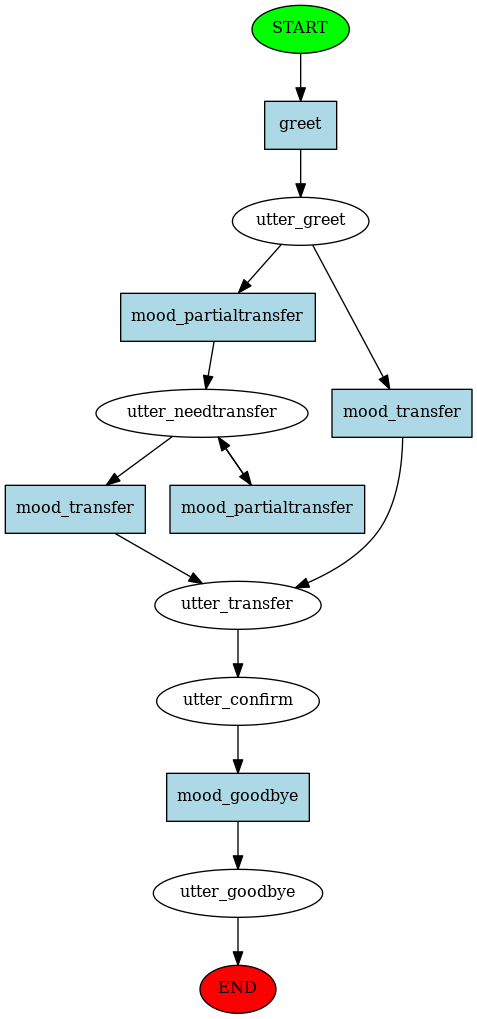

In [76]:
from rasa_core.agent import Agent
from IPython.display import Image

agent = Agent.load('models/dialogue')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

# Part 3: Next steps

Great job! You've built your first bot that uses Machine Learning to manage dialogues. As a next step, we'd suggest you start building your own bot. Here are a few useful links:



*   Install the Rasa Stack on your machine [here](https://core.rasa.ai/installation.html)
*   Learn how to bootstrap training data with the [interactive learning tutorial](https://core.rasa.ai/tutorial_interactive_learning.html)
*   Connect to the community in our [Gitter Chat](https://gitter.im/RasaHQ/rasa_core)



---




*Any feedback for this tutorial?* Please shoot us an email at hi@rasa.com